## Basic library to import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm 
from matplotlib.ticker import LogLocator, NullFormatter
import pandas as pd
from scipy import optimize
from scipy.linalg import lu_factor, lu_solve
from scipy import optimize
from scipy.constants import mu_0, epsilon_0
from scipy.special import roots_legendre
from scipy.interpolate import InterpolatedUnivariateSpline as iuSpline

## Specific library to import

In [2]:
import discretize
import empymod

## Project package to import

In [3]:
import Project
from Project import EMIP1D
from Project import psuedolog

In [4]:
res_air = 2e14
res_sea = 1/3
btm_fix = True
res_btm = 1.
nlayers = 1

layer_thicknesses = 40.
seabed_depth = 1004.
depth = np.hstack([np.r_[0],seabed_depth+layer_thicknesses * np.arange(nlayers+1)])

In [5]:
# Configuration is inspired by JOGMEC WISTEM survey
# K.Nakayama(2014)
t = np.logspace(-4,-2, 61)
tstrt = 1e-4
tend = 1e-2
tindex = (t >= tstrt) & (t <= tend)
tplot = t[tindex]*1e3

In [6]:

model_base = {
    'src':  [1.75,1.75,0,1.75,1000, 1000],
    'rec': [0,0,1000,0,90],
    'depth': depth,
    'freqtime': t ,
    'signal': 0,
    'mrec' : True,
    'verb': 0
}

In [7]:
EMIP =  EMIP1D(IP_model="pelton",model_base=model_base, 
res_air=res_air,res_sea=res_sea, nlayers=nlayers, tindex=tindex,
btm_fix=btm_fix, res_btm=res_btm)

In [8]:
res = 0.2 * np.ones(nlayers)
m_r = np.log(res)
m = 0.6
m_m = m 
m_t = np.log(1e-4)*np.ones(nlayers)
m_c = 0.5*np.ones(nlayers)
mvec_obs = np.hstack([m_r, m_m,m_t,m_c])
data_clean = EMIP.predicted_data(mvec_obs)

In [9]:
relative_error=0.01
np.random.seed(0)
data_obs =  data_clean + np.random.randn(len(data_clean)) * relative_error * np.abs(data_clean)

In [10]:
res = 1.* np.ones(nlayers)
m_r = np.log(res)
m_m = 1e-5
m_t = np.log(1e-3)*np.ones(nlayers)
m_c = 0.6*np.ones(nlayers)
mvec_init = np.hstack([m_r, m_m, m_t, m_c])
data_init = EMIP.predicted_data(mvec_init)

## Prepare matrix for regularization

In [11]:
EMIP.get_ip_model(mvec_init)

{'res': array([2.00000000e+14, 3.33333333e-01, 1.00000000e+00, 1.00000000e+00]),
 'rho_0': array([2.00000000e+14, 3.33333333e-01, 1.00000000e+00, 1.00000000e+00]),
 'm': array([0.e+00, 0.e+00, 1.e-05, 0.e+00]),
 'tau': array([0.001, 0.001, 0.001, 0.001]),
 'c': array([0.5, 0.5, 0.6, 0.5]),
 'func_eta': <bound method EMIP1D.pelton_et_al of <Project.EMIP1D object at 0x0000013DEA049910>>}

In [12]:
Wd = EMIP.get_Wd(dobs=data_obs,dp=1,ratio=0.01,plateau=1e-5)
#Wd = np.diag(np.ones(len(data_obs)))
Ws = EMIP.get_Ws()
Wx = EMIP.get_Wx()

No smoothness for one layer model


In [13]:
niter = 20
beta = 1
alphas = 1
alphax = 0.
stol= 1e-2
mu = -1
# mvec_pred, error, model_itr = EMIP.GaussNewton_smooth(
#     dobs=data_obs, mvec_init=mvec_init, niter=niter, Wd =Wd,
#     beta=beta, Ws = Ws, Wx=Wx, alphas=alphas, alphax=alphax)
mvec_pred, error, model_itr = EMIP.GaussNewton_smooth(
    dobs=data_obs, mvec_init=mvec_init, niter=niter, Wd =Wd,
    beta=beta, Ws = Ws, Wx=Wx, alphas=alphas, alphax=alphax,
    stol=stol,mu=mu
)
# mvec_pred, error, model_itr = EMIP.GaussNewton_Reg_LS(
#     dobs=data_obs, model_init=mvec_init, niter=niter,beta=beta,
#     atol=1e-14, mu= 1e-4
# )


Gauss-Newton 
 Initial phid = 1.68e+04 ,phim = 0.00e+00, error= 1.68e+04 
  1, step:5.00e-01, gradient:8.36e+03, phid:1.15e+04, phim:2.04e+00, f:1.15e+04 
  2, step:1.00e+00, gradient:6.08e+04, phid:5.48e+02, phim:1.45e+00, f:5.49e+02 
  3, step:1.00e+00, gradient:7.86e+03, phid:6.83e+01, phim:2.05e+00, f:7.04e+01 
  4, step:1.00e+00, gradient:9.75e+02, phid:3.02e+01, phim:6.66e+00, f:3.68e+01 
  5, step:2.50e-01, gradient:2.40e+02, phid:3.47e+01, phim:5.17e+00, f:3.99e+01 
  6, step:1.00e+00, gradient:1.32e+03, phid:1.93e+01, phim:4.23e+00, f:2.35e+01 
  7, step:1.00e+00, gradient:9.67e+01, phid:1.85e+01, phim:4.79e+00, f:2.33e+01 
  8, step:1.00e+00, gradient:5.98e+01, phid:1.87e+01, phim:4.55e+00, f:2.33e+01 
  9, step:1.00e+00, gradient:1.33e+01, phid:1.86e+01, phim:4.71e+00, f:2.33e+01 
 10, step:1.00e+00, gradient:5.00e+00, phid:1.86e+01, phim:4.63e+00, f:2.33e+01 
 11, step:1.00e+00, gradient:1.03e+00, phid:1.86e+01, phim:4.67e+00, f:2.33e+01 
 12, step:1.00e+00, gradient:5.57e-

In [14]:
data_pred = (EMIP.predicted_data(mvec_pred))

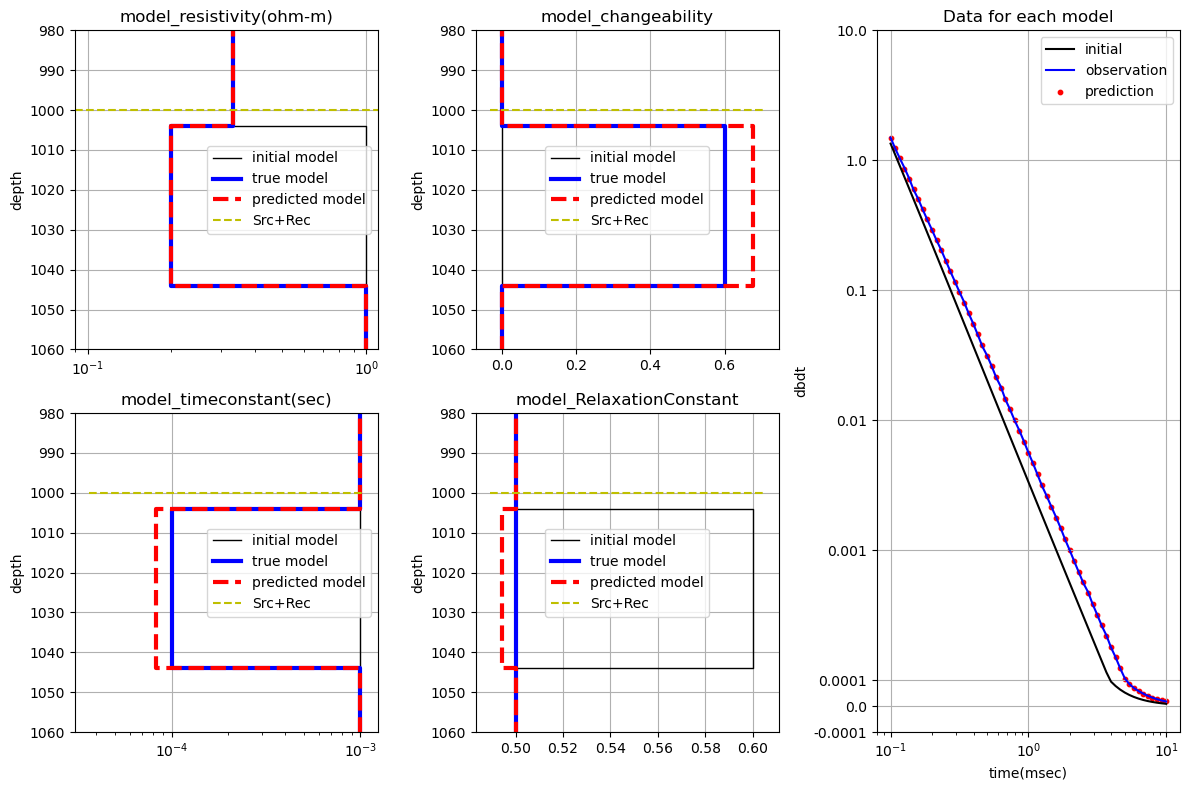

In [15]:
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 3)  
ax = [None] * 5

ax[0] = fig.add_subplot(gs[0, 0])
ax[1] = fig.add_subplot(gs[0, 1])
ax[2] = fig.add_subplot(gs[1, 0])
ax[3] = fig.add_subplot(gs[1, 1])
ax[4] = fig.add_subplot(gs[:, 2])

axip =[ax[0], ax[1], ax[2], ax[3]]
axip = EMIP.plot_IP_par(mvec=mvec_init, label="initial model", color="k-",  ax=axip, linewidth=1.0)
axip = EMIP.plot_IP_par(mvec=mvec_obs,  label="true model",    color="b-",  ax=axip, linewidth=3.0)
axip = EMIP.plot_IP_par(mvec=mvec_pred, label="predicted model",color="r--",ax=axip, linewidth=3.0)
ax[0].set_xlim([0.09,1.1])


for i in range(2):
    tr_min, tr_max = ax[2*i].get_xlim()
    tr_z = np.linspace(tr_min, tr_max, 10)  # Adjust the number of points as needed
    ax[2*i].semilogx(tr_z, model_base["src"][4]* np.ones_like(tr_z), "--y",label="Src+Rec")
for i in range(2):
    tr_min, tr_max = ax[2*i+1].get_xlim()
    tr_z = np.linspace(tr_min, tr_max, 10)  # Adjust the number of points as needed
    ax[2*i+1].plot(tr_z, model_base["src"][4]* np.ones_like(tr_z), "--y",label="Src+Rec")

data_plot = psuedolog(posmax=1e1, negmax=1e-4, a=1e-4, b=0.2)
ax[4] = data_plot.pl_plot(tplot, data_init, ax=ax[4], color="k", label="initial")
ax[4] = data_plot.pl_plot(tplot, data_obs , ax=ax[4], color="b", label="observation")
ax[4] = data_plot.pl_scatter(tplot, data_pred, ax=ax[4], marker="o",s=10,color="r", label="prediction")
ax[4] = data_plot.pl_axes(ax[4])
ax[4].set_title("Data for each model")
ax[4].set_ylabel("dbdt")

ax[4].legend()
ax[4].set_xlabel("time(msec)")

for i in range(4):  # Iterate over rows
    ax[i].set_ylim([1060, 980])
    ax[i].set_ylabel('depth')
    ax[i].legend()
    ax[i].grid()
    if i== 0 or i ==2:
        ax[i].set_xscale("log")
    else:
        ax[i].set_xscale("linear")
plt.tight_layout()
plt.savefig("3_objgrid_pelton_h4m_model_data.png",dpi=300)
plt.show()

In [16]:
itr_st = 0
mrlim = [ [ min(np.r_[model_itr[itr_st:,0],mvec_obs[0]]), 
           max(np.r_[model_itr[itr_st:,0],mvec_obs[0]])]]
mmlim = [ [ min(np.r_[model_itr[itr_st:,1],mvec_obs[1]]), 
           max(np.r_[model_itr[itr_st:,1],mvec_obs[1]])]]
mtlim = [ [ min(np.r_[model_itr[itr_st:,2],mvec_obs[2]]), 
           max(np.r_[model_itr[itr_st:,2],mvec_obs[2]])]]
mclim = [ [ min(np.r_[model_itr[itr_st:,3],mvec_obs[3]]), 
           max(np.r_[model_itr[itr_st:,3],mvec_obs[3]])]]
print(mrlim)
print(mmlim)
print(mtlim)
print(mclim)

[[-1.9338705206442668, 0.0]]
[[1e-05, 0.7732460844661908]]
[[-10.102216236712914, -6.907755278982137]]
[[0.4, 0.6]]


In [17]:
ngrid = 50
mirgin = 0.1
# m_t = mvec_obs[2]
# m_c = mvec_obs[3]
m_t = model_itr[-1,2]
m_c = model_itr[-1,3]

rm_grid, mm_grid, mr_grid = EMIP.get_rm_grid( mrlim=mrlim, mmlim=mmlim,
m_t=m_t, m_c=m_c, dobs=data_obs, mref=mvec_init, Wd=Wd, 
beta=beta, Ws=Ws, Wx=Wx, alphas=alphas, alphax=alphax,ngrid=ngrid) 

In [18]:
# m_r = mvec_obs[0]
# m_m = mvec_obs[1]
m_r = model_itr[-1,0]
m_m = model_itr[-1,1]
tc_grid, mt_grid, mc_grid = EMIP.get_tc_grid( m_r=m_r, m_m=m_m,
mtlim=mtlim, mclim=mclim, dobs=data_obs, mref=mvec_init, Wd=Wd, 
beta=beta, Ws=Ws, Wx=Wx, alphas=alphas, alphax=alphax,ngrid=ngrid) 

In [19]:
res_grid = np.exp(mr_grid)
chg_grid = mm_grid
# res0_grid = np.exp(m0_grid)
# res8_grid = np.exp(m8_grid)
res_tr = np.exp(model_itr[itr_st:,0])
chg_tr = model_itr[itr_st:,1]
tau_grid = np.exp(mt_grid)
c_grid = mc_grid
tau_tr = np.exp(model_itr[itr_st:,2])
c_tr = model_itr[itr_st:,3]

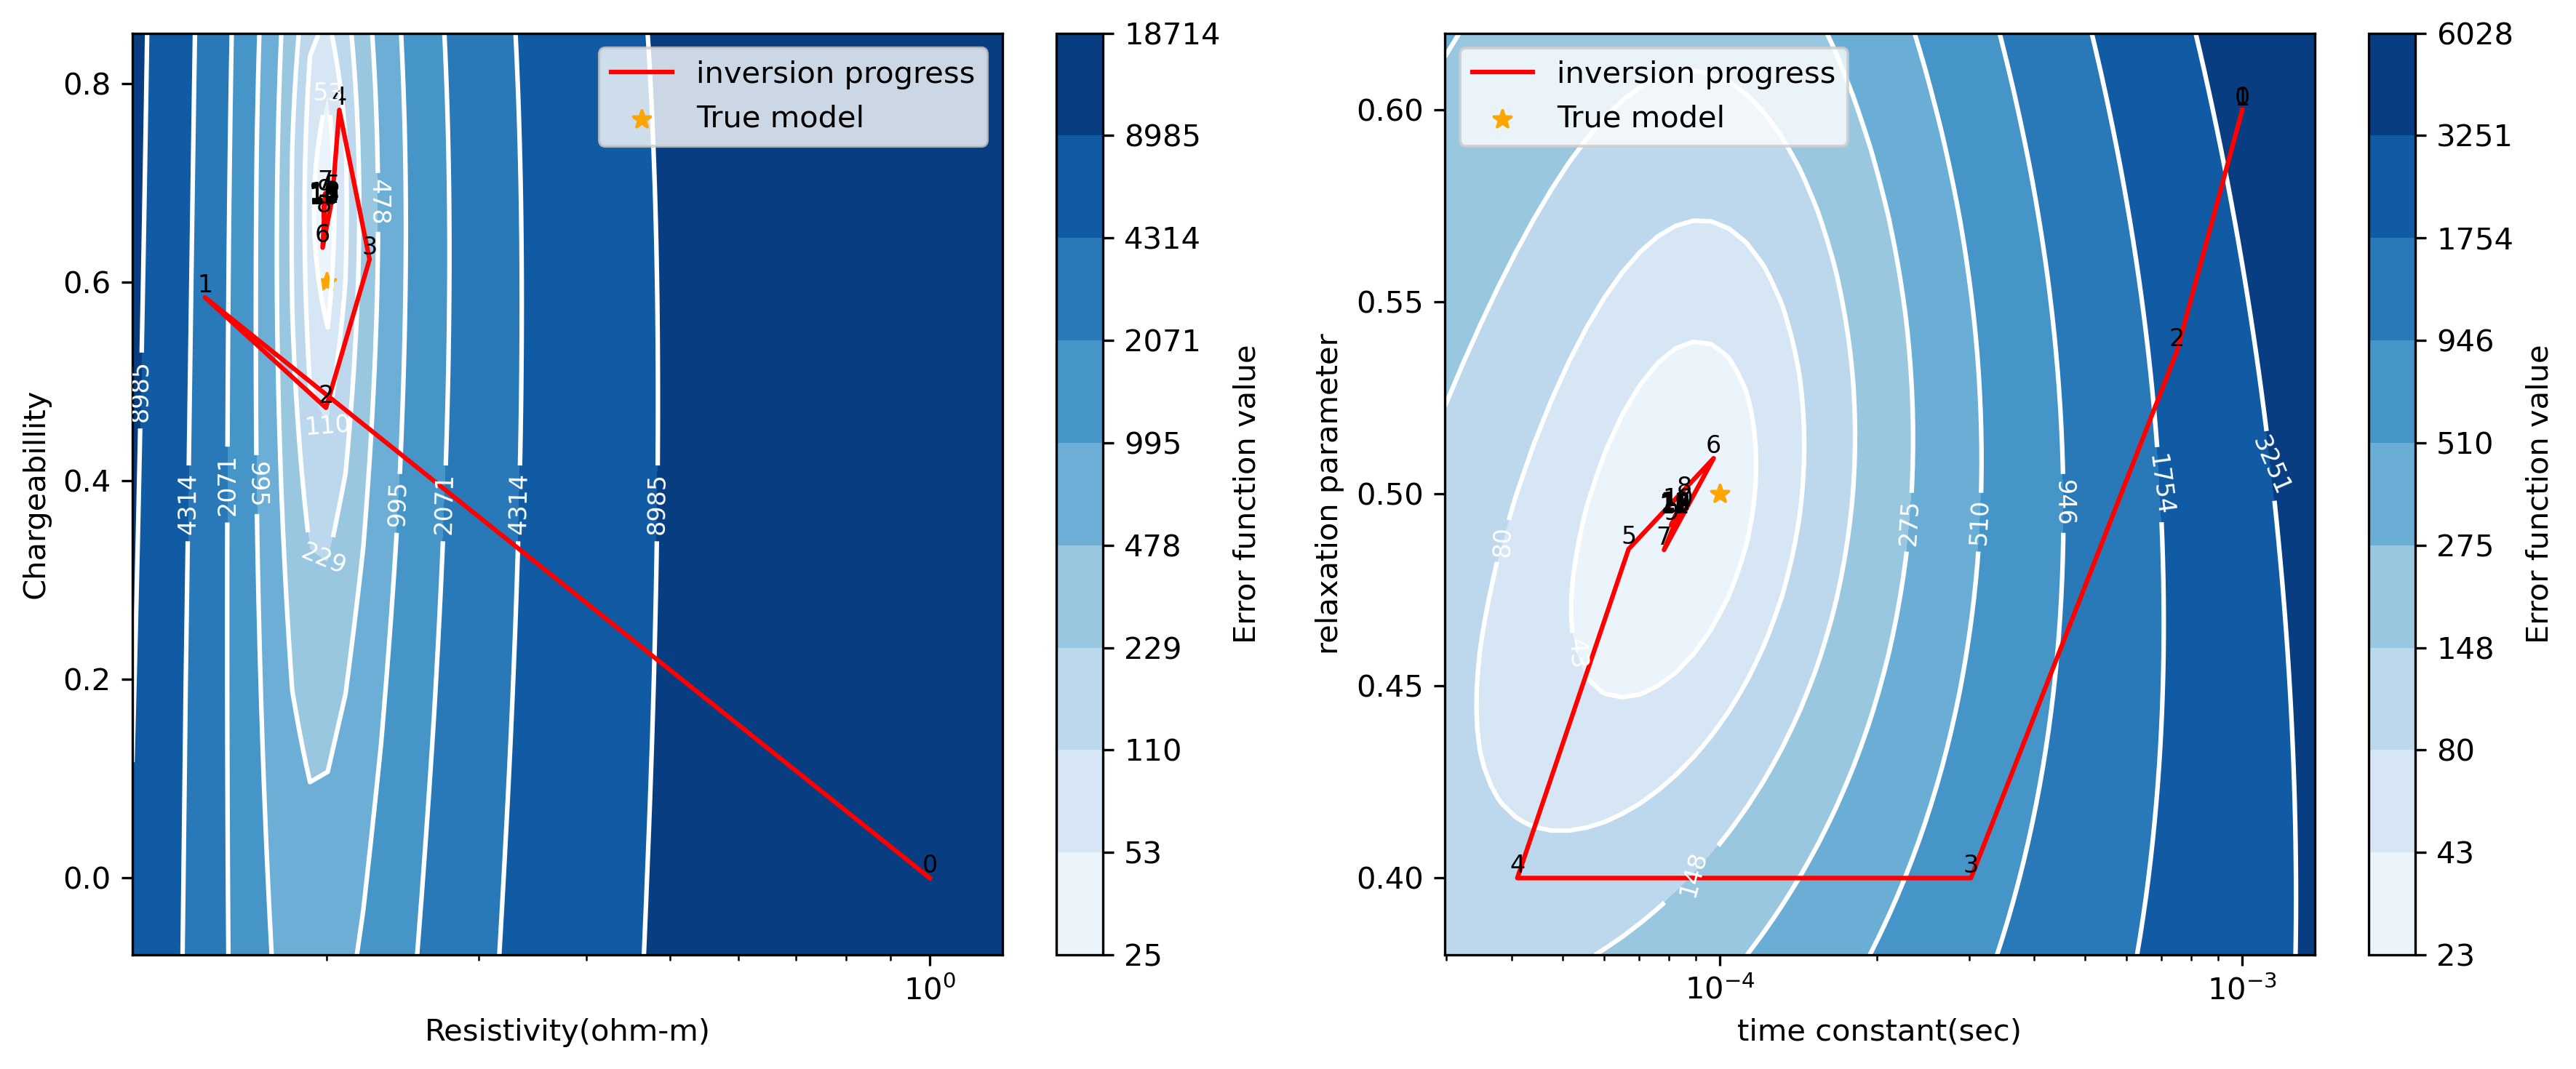

In [20]:
fig, ax = plt.subplots(1, 2,figsize=(12, 5),dpi=300)
# levels = np.logspace( np.log10( np.min( cc_grid) ), np.log10( np.max(cc_grid) ),10)
levels = np.logspace( np.log10( np.min( rm_grid) ), np.log10( np.max(rm_grid) ),10)

# Create a logarithmically spaced colormap
cmap = plt.cm.Blues
norm = mcolors.LogNorm(vmin=np.min(rm_grid), vmax=np.max(rm_grid))

CF = ax[0].contourf(res_grid, chg_grid, rm_grid, levels=levels, cmap=cmap, norm=norm)
CS = ax[0].contour(res_grid, chg_grid, rm_grid, levels=levels, colors="w")
CL = ax[0].clabel(CS, inline=True, fontsize=8)

CB = fig.colorbar(CF, ax=ax[0])

ax[0].plot(res_tr,chg_tr,"r",label="inversion progress")
for i, (x, y) in enumerate(zip(res_tr, chg_tr)):
    ax[0].text(x, y, str(itr_st+i), fontsize=8, color='black', ha='center', va='bottom')
# ax.plot(np.exp(model_obs[0]),np.exp(model_obs[1]),"r*")
ax[0].scatter(np.exp(mvec_obs[0]),mvec_obs[1],color="orange", marker="*",label="True model")

CB.set_label("Error function value")
ax[0].set_yscale('linear')  
ax[0].set_xscale('log')  
ax[0].set_xlabel("Resistivity(ohm-m)")
ax[0].set_ylabel("Chargeabillity")

levels = np.logspace( np.log10( np.min( tc_grid) ), np.log10( np.max(tc_grid) ),10)

# Create a logarithmically spaced colormap
cmap = plt.cm.Blues
norm = mcolors.LogNorm(vmin=np.min(tc_grid), vmax=np.max(tc_grid))

CF = ax[1].contourf(tau_grid, c_grid, tc_grid, levels=levels, cmap=cmap, norm=norm)
CS = ax[1].contour( tau_grid, c_grid, tc_grid, levels=levels, colors="w")
CL = ax[1].clabel(CS, inline=True, fontsize=8)

CB = fig.colorbar(CF, ax=ax[1])

ax[1].plot(tau_tr,c_tr,"r",label="inversion progress")
for i, (x, y) in enumerate(zip(tau_tr, c_tr)):
    ax[1].text(x, y, str(itr_st+i), fontsize=8, color='black', ha='center', va='bottom')
# ax.plot(np.exp(model_obs[0]),np.exp(model_obs[1]),"r*")
ax[1].scatter(np.exp(mvec_obs[2]),mvec_obs[3], color="orange", marker="*",label="True model")
CB.set_label("Error function value")
ax[1].set_yscale('linear')  
ax[1].set_xscale('log')  
ax[1].set_xlabel("time constant(sec)")
ax[1].set_ylabel("relaxation parameter")
for a in ax:
    a.legend()
#     axes.set_xticklabels(axes.get_xticklabels(), rotation=45)  # Adjust the rotation angle as needed

plt.tight_layout()
plt.savefig("3_objgrid_pelton_h4m.png",dpi=300)
plt.show()

In [21]:
itr_st = 5
mrlim = [ [ min(np.r_[model_itr[itr_st:,0],mvec_obs[0]]), 
           max(np.r_[model_itr[itr_st:,0],mvec_obs[0]])]]
mmlim = [ [ min(np.r_[model_itr[itr_st:,1],mvec_obs[1]]), 
           max(np.r_[model_itr[itr_st:,1],mvec_obs[1]])]]
mtlim = [ [ min(np.r_[model_itr[itr_st:,2],mvec_obs[2]]), 
           max(np.r_[model_itr[itr_st:,2],mvec_obs[2]])]]
mclim = [ [ min(np.r_[model_itr[itr_st:,3],mvec_obs[3]]), 
           max(np.r_[model_itr[itr_st:,3],mvec_obs[3]])]]
print(mrlim)
print(mmlim)
print(mtlim)
print(mclim)

[[-1.619911110506223, -1.5939582030403645]]
[[0.6, 0.6893820556362857]]
[[-9.61185456401627, -9.210340371976182]]
[[0.4854410036149852, 0.509309816694808]]


In [22]:
ngrid = 50
mirgin = 0.1
# m_t = mvec_obs[2]
# m_c = mvec_obs[3]
m_t = model_itr[-1,2]
m_c = model_itr[-1,3]
rm_grid, mm_grid, mr_grid = EMIP.get_rm_grid( mrlim=mrlim, mmlim=mmlim,
m_t=m_t, m_c=m_c, dobs=data_obs, mref=mvec_init, Wd=Wd, 
beta=beta, Ws=Ws, Wx=Wx, alphas=alphas, alphax=alphax,ngrid=ngrid) 

In [23]:
# m_r = mvec_obs[0]
# m_m = mvec_obs[1]
m_r = model_itr[-1,0]
m_m = model_itr[-1,1]
tc_grid, mt_grid, mc_grid = EMIP.get_tc_grid( m_r=m_r, m_m=m_m,
mtlim=mtlim, mclim=mclim, dobs=data_obs, mref=mvec_init, Wd=Wd, 
beta=beta, Ws=Ws, Wx=Wx, alphas=alphas, alphax=alphax,ngrid=ngrid) 

In [24]:
res_grid = np.exp(mr_grid)
chg_grid = mm_grid
# res0_grid = np.exp(m0_grid)
# res8_grid = np.exp(m8_grid)
res_tr = np.exp(model_itr[itr_st:,0])
chg_tr = model_itr[itr_st:,1]
tau_grid = np.exp(mt_grid)
c_grid = mc_grid
tau_tr = np.exp(model_itr[itr_st:,2])
c_tr = model_itr[itr_st:,3]

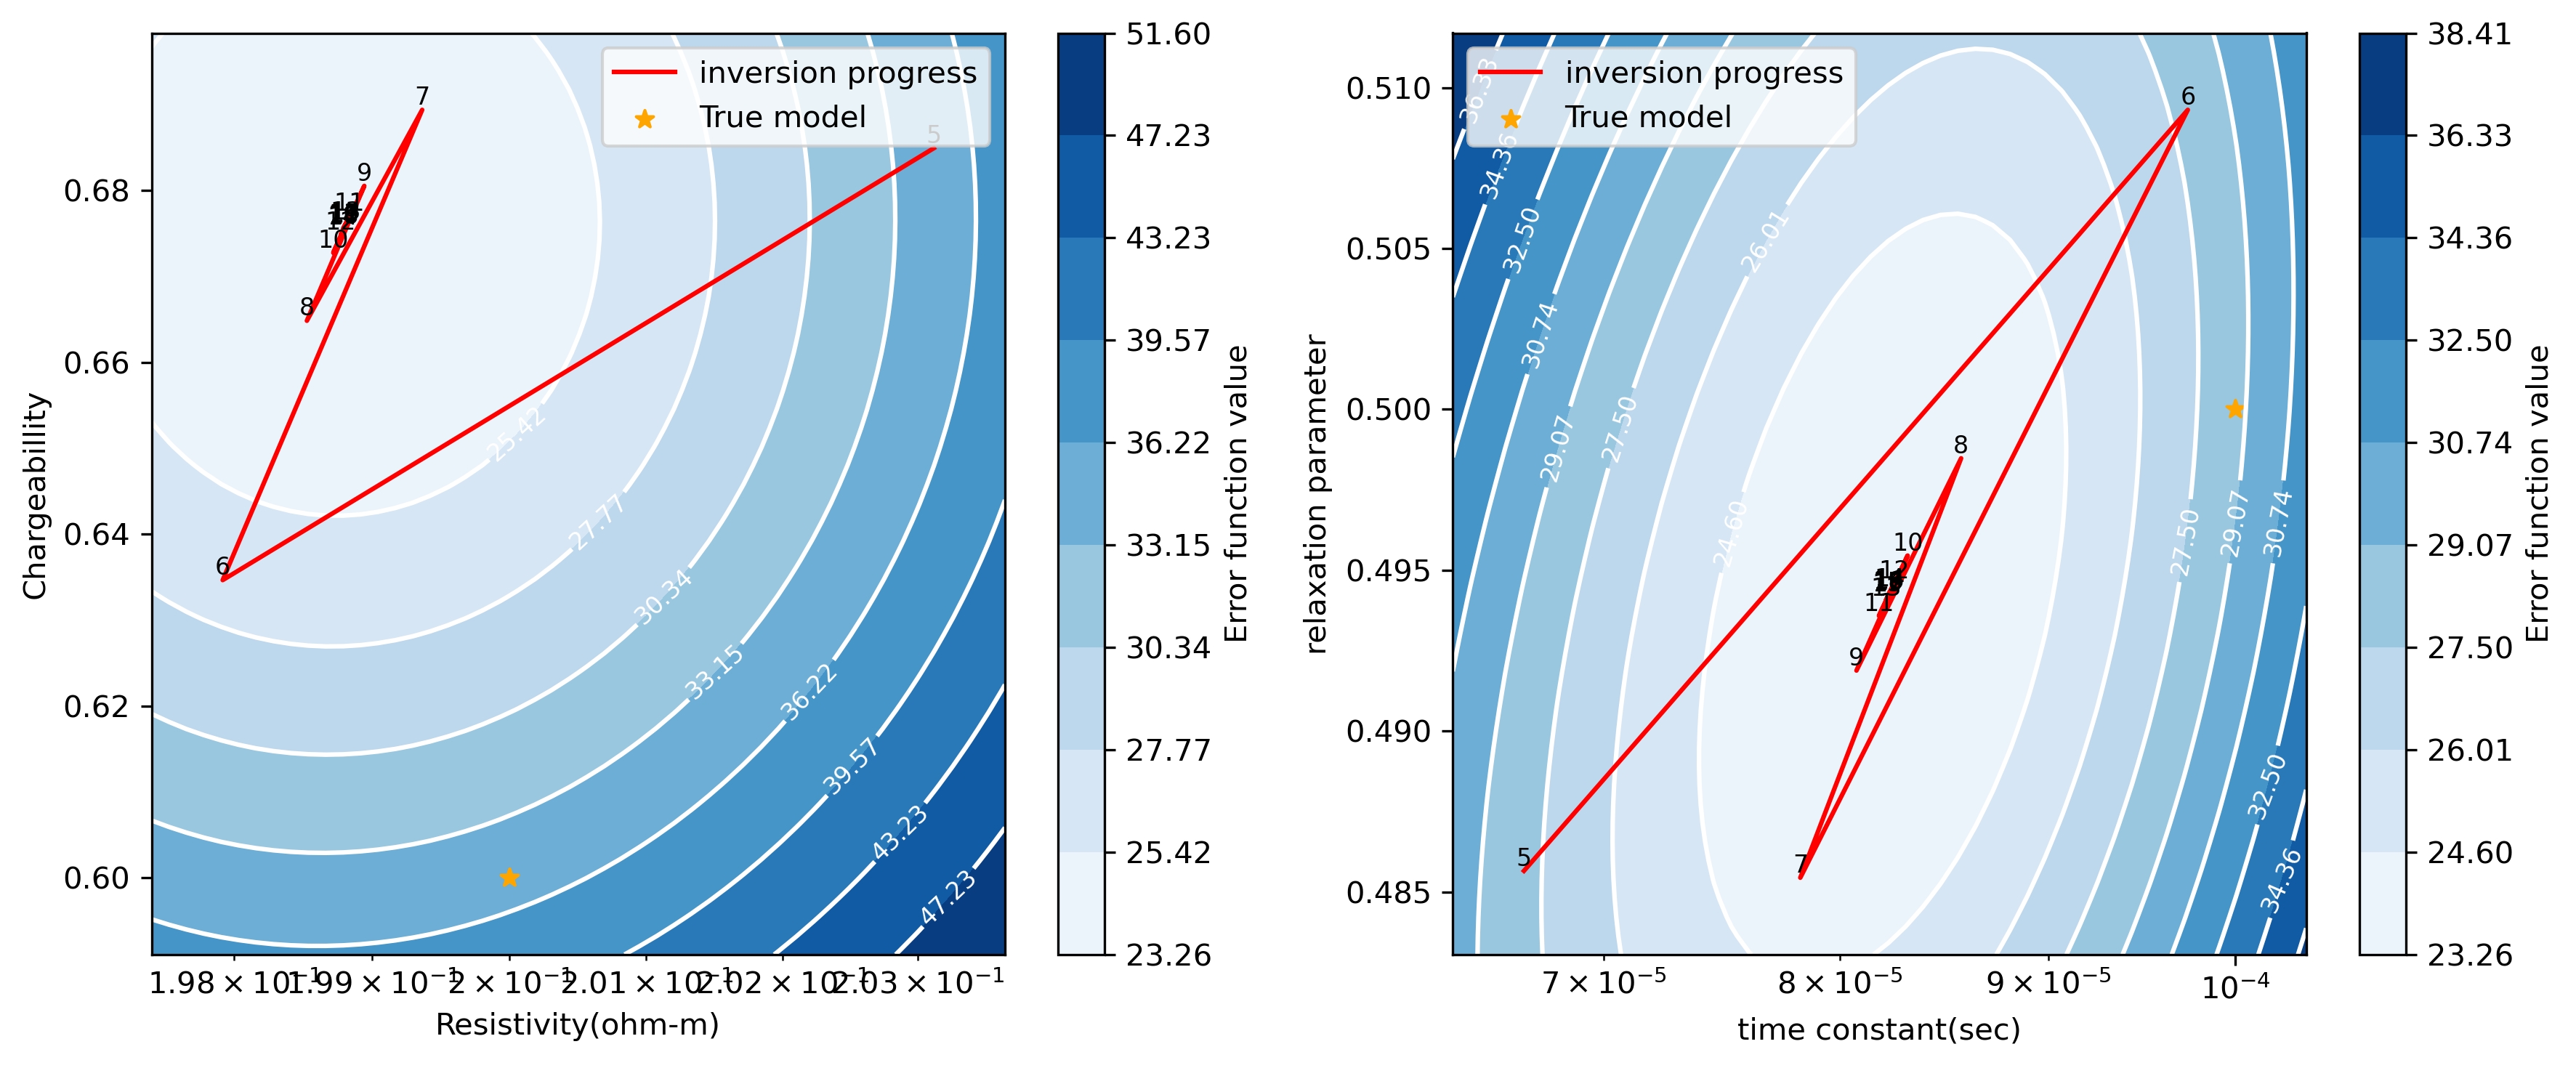

In [25]:
fig, ax = plt.subplots(1, 2,figsize=(12, 5),dpi=300)
# levels = np.logspace( np.log10( np.min( cc_grid) ), np.log10( np.max(cc_grid) ),10)
levels = np.logspace( np.log10( np.min( rm_grid) ), np.log10( np.max(rm_grid) ),10)

# Create a logarithmically spaced colormap
cmap = plt.cm.Blues
norm = mcolors.LogNorm(vmin=np.min(rm_grid), vmax=np.max(rm_grid))

CF = ax[0].contourf(res_grid, chg_grid, rm_grid, levels=levels, cmap=cmap, norm=norm)
CS = ax[0].contour(res_grid, chg_grid, rm_grid, levels=levels, colors="w")
CL = ax[0].clabel(CS, inline=True, fontsize=8)

CB = fig.colorbar(CF, ax=ax[0])

ax[0].plot(res_tr,chg_tr,"r",label="inversion progress")
for i, (x, y) in enumerate(zip(res_tr, chg_tr)):
    ax[0].text(x, y, str(itr_st+i), fontsize=8, color='black', ha='center', va='bottom')
# ax.plot(np.exp(model_obs[0]),np.exp(model_obs[1]),"r*")
ax[0].scatter(np.exp(mvec_obs[0]),mvec_obs[1],color="orange", marker="*",label="True model")

CB.set_label("Error function value")
ax[0].set_yscale('linear')  
ax[0].set_xscale('log')  
ax[0].set_xlabel("Resistivity(ohm-m)")
ax[0].set_ylabel("Chargeabillity")

levels = np.logspace( np.log10( np.min( tc_grid) ), np.log10( np.max(tc_grid) ),10)

# Create a logarithmically spaced colormap
cmap = plt.cm.Blues
norm = mcolors.LogNorm(vmin=np.min(tc_grid), vmax=np.max(tc_grid))

CF = ax[1].contourf(tau_grid, c_grid, tc_grid, levels=levels, cmap=cmap, norm=norm)
CS = ax[1].contour( tau_grid, c_grid, tc_grid, levels=levels, colors="w")
CL = ax[1].clabel(CS, inline=True, fontsize=8)

CB = fig.colorbar(CF, ax=ax[1])

ax[1].plot(tau_tr,c_tr,"r",label="inversion progress")
for i, (x, y) in enumerate(zip(tau_tr, c_tr)):
    ax[1].text(x, y, str(itr_st+i), fontsize=8, color='black', ha='center', va='bottom')
# ax.plot(np.exp(model_obs[0]),np.exp(model_obs[1]),"r*")
ax[1].scatter(np.exp(mvec_obs[2]),mvec_obs[3], color="orange", marker="*",label="True model")
CB.set_label("Error function value")
ax[1].set_yscale('linear')  
ax[1].set_xscale('log')  
ax[1].set_xlabel("time constant(sec)")
ax[1].set_ylabel("relaxation parameter")
for a in ax:
    a.legend()
#     axes.set_xticklabels(axes.get_xticklabels(), rotation=45)  # Adjust the rotation angle as needed

plt.tight_layout()
plt.savefig("3_objgrid_pelton_h4m_05-20.png",dpi=300)
plt.show()